In [70]:
import math
import time
import calendar
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf

In [71]:
river_df = pd.read_csv('riverlevel.csv')

# convert month name to integer
month_dict = dict((v, k) for k, v in enumerate(calendar.month_name))
river_df['Month'] = river_df['Month'].map(month_dict)

# create datetime column
river_df[['Year', 'Month', 'Day', 'Hour']] = river_df[['Year', 'Month', 'Day', 'Hour']].astype(int)
river_df['Hour'] = river_df['Hour'].apply(lambda x: x if x < 24 else 0)
river_df['Datetime'] = river_df[['Year', 'Month', 'Day', 'Hour']].apply(lambda row: datetime(row['Year'], row['Month'], row['Day'], row['Hour']).isoformat(), axis=1)
river_df["Datetime"] = pd.to_datetime(river_df["Datetime"], format='ISO8601')

# make datetime as index
river_df.index = river_df["Datetime"]
river_df = river_df.drop(['Datetime'], axis=1)

# remove non numeric fields
river_df = river_df[['Waterlevel', 'Waterlevel.1', 'Waterlevel.2', 'RF-Intensity', 'RF-Intensity.1', 'Precipitation', 'Humidity', 'Temperature']]
river_df = river_df.astype(np.float64)

# resolve missing values
river_df = river_df.interpolate(method='linear', limit_direction='forward')
river_df = river_df.resample('24H').max()

river_df

,Waterlevel,Waterlevel.1,Waterlevel.2,RF-Intensity,RF-Intensity.1,Precipitation,Humidity,Temperature
Datetime,,,,,,,,
2012-01-01,15.94,12.53,21.97,0.0,0.0,0.08,18.01,28.69
2012-01-02,15.86,12.52,21.96,0.0,4.0,0.41,17.88,28.08
2012-01-03,15.94,12.51,21.94,7.0,4.0,1.64,17.88,27.39
2012-01-04,16.00,12.50,22.03,0.0,0.0,1.41,17.82,27.20
2012-01-05,15.85,12.49,22.01,0.0,0.0,0.35,16.36,26.10
...,...,...,...,...,...,...,...,...
2022-12-27,15.87,12.22,21.30,0.0,0.0,0.46,14.71,23.97
2022-12-28,15.87,12.19,21.30,0.0,1.0,2.95,15.81,25.87
2022-12-29,15.87,12.17,21.30,0.0,1.0,1.29,18.43,25.80


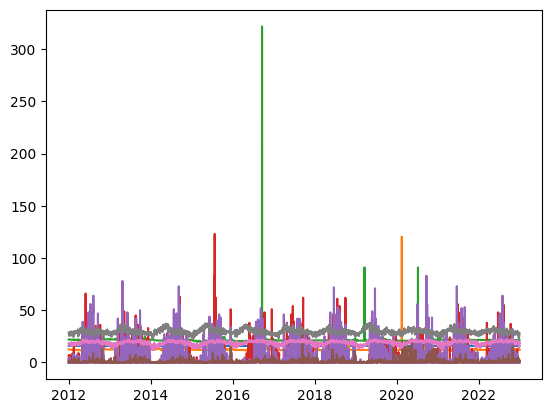

In [72]:
plt.plot(river_df)
plt.show()

(3989, 8)
Waterlevel


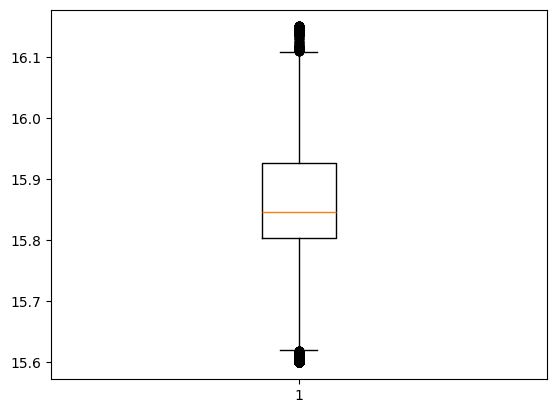

Waterlevel.1


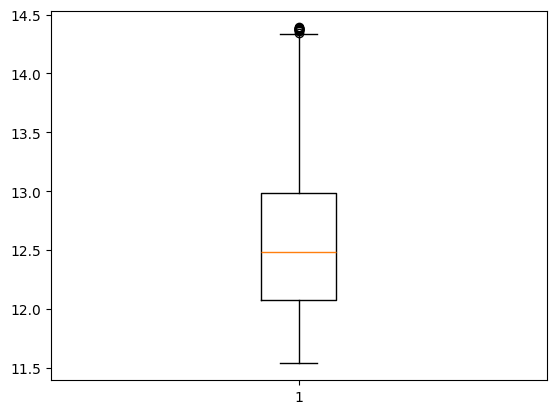

Waterlevel.2


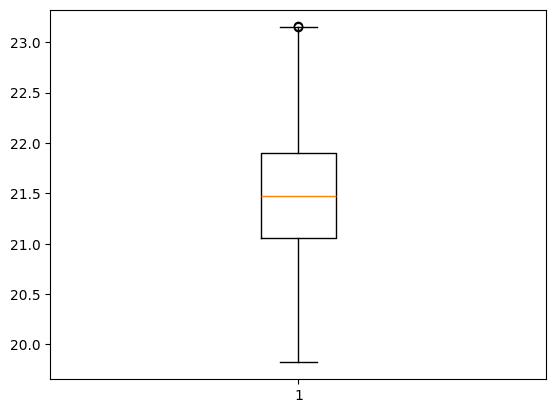

RF-Intensity


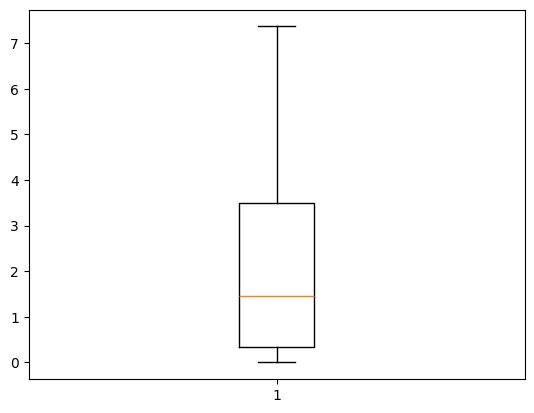

RF-Intensity.1


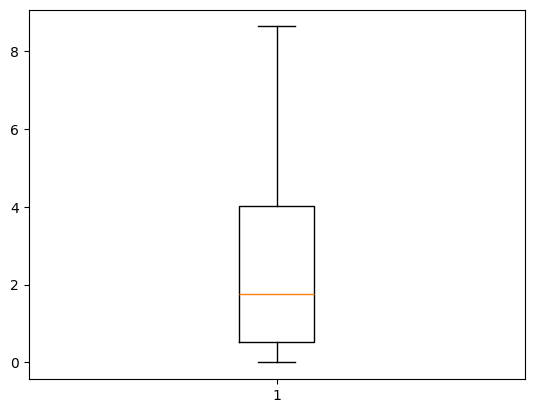

Precipitation


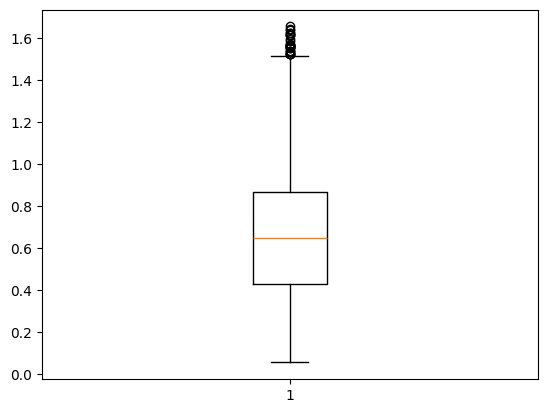

Humidity


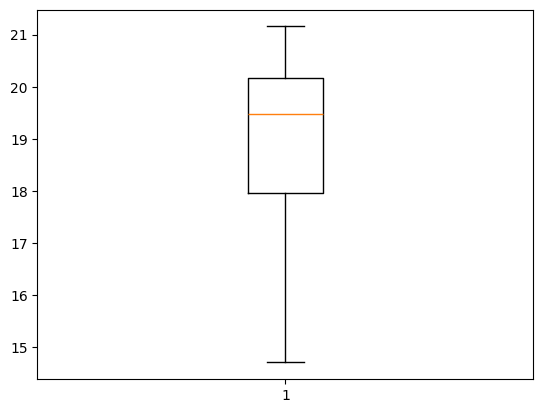

Temperature


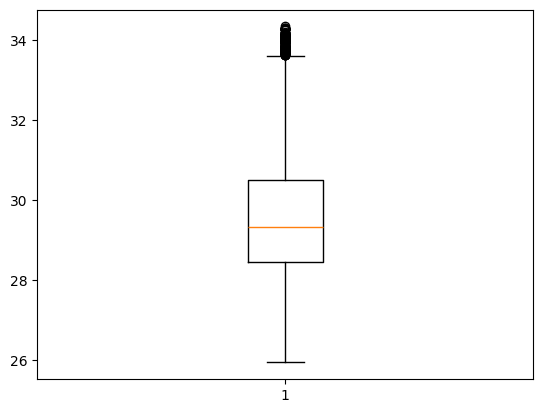

In [73]:
# remove outliers
river_df['Waterlevel'] = river_df['Waterlevel'].clip(upper=16.15, lower=15.60)
river_df['Waterlevel.1'] = river_df['Waterlevel.1'].clip(upper=14.50, lower=10.00)
river_df['Waterlevel.2'] = river_df['Waterlevel.2'].clip(upper=23.20, lower=15.00)
river_df['RF-Intensity'] = river_df['RF-Intensity'].clip(upper=11.00, lower=0.00)
river_df['RF-Intensity.1'] = river_df['RF-Intensity.1'].clip(upper=11.00, lower=0.00)
river_df['Precipitation'] = river_df['Precipitation'].clip(upper=2.00, lower=0.00)
river_df['Humidity'] = river_df['Humidity'].clip(upper=50.00, lower=12.00)
river_df['Temperature'] = river_df['Temperature'].clip(upper=34.50, lower=23.50)

# smoothen again to prevent stagnant values
river_df = river_df.rolling(30).mean().dropna()
print(river_df.values.shape)

for col in river_df.columns:
    print(col)
    plt.boxplot(river_df[col])
    plt.show()

In [74]:
train_df = river_df['2012-01-01': '2020-01-01']
test_df = river_df['2020-01-01': '2023-01-01']

print(train_df.shape)
print(test_df.shape)

(2894, 8)
(1096, 8)


In [75]:
PRED_LEN = 730 
LABEL_LEN = 365 
D_MODEL = 8 
D_FF = 2048
N_HEADS = 4 
DEC_LAYERS = 2
BATCH_SIZE = 64

In [76]:
def get_windows(ds, windows_size):
    scaler = MinMaxScaler()
    scaled_ds = scaler.fit_transform(ds)
    
    windows = [scaled_ds[i:(i+(windows_size))] for i in range(0, len(scaled_ds) - windows_size, 1)]
    
    return np.array(windows)

In [77]:
# split dataset for training
train_data = get_windows(train_df, windows_size=PRED_LEN)
val_data = get_windows(test_df, windows_size=PRED_LEN)
test_data = get_windows(test_df, windows_size=PRED_LEN)

# convert them into tf constants
train_tensors = tf.constant(train_data, dtype=tf.float32)
val_tensors = tf.constant(val_data, dtype=tf.float32)
test_tensors = tf.constant(test_data, dtype=tf.float32)

print(train_tensors.shape)
print(val_tensors.shape)
print(test_tensors.shape)

(2164, 730, 8)
(366, 730, 8)
(366, 730, 8)


In [78]:
def prepare_batch(data):
    X = data[:, :-1, :]  # Drop the [END] tokens
    y = data[:, 1:, :]   # Drop the [START] tokens

    return X, y

def make_batches(ds, batch_size=BATCH_SIZE):
      return (ds.batch(batch_size)
                .map(prepare_batch, tf.data.AUTOTUNE)
                .prefetch(buffer_size=tf.data.AUTOTUNE))
      
train_batches = make_batches(tf.data.Dataset.from_tensor_slices(train_tensors))
val_batches = make_batches(tf.data.Dataset.from_tensor_slices(val_tensors))
test_batches = make_batches(tf.data.Dataset.from_tensor_slices(test_tensors))

for X_test, y_test in test_batches.take(1):
    break

print(X_test.shape)
print(y_test.shape)

(64, 729, 8)
(64, 729, 8)


In [79]:
class FeedForward(tf.keras.layers.Layer):
    def __init__(self, d_ff, d_model, **kwargs):
        super(FeedForward, self).__init__(**kwargs)
        self.fully_connected1 = tf.keras.layers.Dense(d_ff)  # First fully connected layer
        self.fully_connected2 = tf.keras.layers.Dense(d_model)  # Second fully connected layer
        self.activation = tf.keras.layers.ReLU()  # ReLU activation layer
        
    def call(self, x):
        # The input is passed into the two fully-connected layers, with a ReLU in between
        x = self.fully_connected1(x)
        return self.fully_connected2(self.activation(x))

In [80]:
class AddNormalization(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(AddNormalization, self).__init__(**kwargs)
        self.layer_norm = tf.keras.layers.LayerNormalization()  # Layer normalization layer

    def call(self, x, sublayer_x):
        # The sublayer input and output need to be of the same shape to be summed
        add = x + sublayer_x

        # Apply layer normalization to the sum
        return self.layer_norm(add)

In [81]:
class PositionEmbeddingFixedWeights(tf.keras.layers.Layer):
    def __init__(self, sequence_length, output_dim, **kwargs):
        super(PositionEmbeddingFixedWeights, self).__init__(**kwargs) 
        position_embedding_matrix = self.get_position_encoding(sequence_length, output_dim)                                          
        self.position_embedding_layer = tf.keras.layers.Embedding(
                                            input_dim=sequence_length, 
                                            output_dim=output_dim, 
                                            weights=[position_embedding_matrix], 
                                            trainable=False)
             
    def get_position_encoding(self, seq_len, d, n=10000):
        P = np.zeros((seq_len, d))
        for k in range(seq_len):
            for i in np.arange(int(d/2)):
                denominator = np.power(n, 2*i/d)
                P[k, 2*i] = np.sin(k/denominator)
                P[k, 2*i+1] = np.cos(k/denominator)
        return P


    def call(self, inputs):        
        position_indices = tf.range(tf.shape(inputs)[1])
        embedded_indices = self.position_embedding_layer(position_indices)
        return inputs + embedded_indices

In [82]:
class DotProductAttention(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(DotProductAttention, self).__init__(**kwargs)

    def call(self, queries, keys, values, d_k, mask=None):
        # Scoring the queries against the keys after transposing the latter, and scaling
        scores = tf.matmul(queries, keys, transpose_b=True) / tf.math.sqrt(tf.cast(d_k, tf.float32))

        # Apply mask to the attention scores
        if mask is not None:
            scores += -1e9 * mask

        # Computing the weights by a softmax operation
        weights = tf.keras.backend.softmax(scores)

        # Computing the attention by a weighted sum of the value vectors
        return tf.matmul(weights, values)

class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, h, d_model, **kwargs):
        super(MultiHeadAttention, self).__init__(**kwargs)
        self.attention = DotProductAttention()  
        self.heads = h  
        self.d_model = d_model  
        self.W_in = tf.keras.layers.Dense(d_model)
        self.W_o = tf.keras.layers.Dense(d_model)  

    def reshape_tensor(self, x, heads, flag=None):
        if flag:
            x = tf.reshape(x, shape=(tf.shape(x)[0], tf.shape(x)[1], heads, -1))
            x = tf.transpose(x, perm=(0, 2, 1, 3))
        else:
            x = tf.transpose(x, perm=(0, 2, 1, 3))
            x = tf.reshape(x, shape=(tf.shape(x)[0], tf.shape(x)[1], self.d_model))
        return x

    def call(self, queries, keys, values, mask=None):
        q_reshaped = self.reshape_tensor(self.W_in(queries), self.heads, True)
       
        k_reshaped = self.reshape_tensor(self.W_in(keys), self.heads, True)
       
        v_reshaped = self.reshape_tensor(self.W_in(values), self.heads, True)
       
        o_reshaped = self.attention(q_reshaped, k_reshaped, v_reshaped, self.d_model, mask)
      
        output = self.reshape_tensor(o_reshaped, self.heads, False)
       
        return self.W_o(output)

In [83]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, h, d_model, d_ff, rate, **kwargs):
        super(DecoderLayer, self).__init__(**kwargs)
        self.multihead_attention = MultiHeadAttention(h, d_model)
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.add_norm1 = AddNormalization()
        self.feed_forward = FeedForward(d_ff, d_model)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        self.add_norm2 = AddNormalization()

    def call(self, x, training):
        # Multi-head attention layer
        shape = x.shape[1]
        lookahead_mask = 1 - tf.linalg.band_part(tf.ones((shape, shape)), -1, 0)
        multihead_output = self.multihead_attention(x, x, x, lookahead_mask)
       
        multihead_output = self.dropout1(multihead_output, training=training)

        
        addnorm_output = self.add_norm1(x, multihead_output)
      
        feedforward_output = self.feed_forward(addnorm_output)
        
        feedforward_output = self.dropout2(feedforward_output, training=training)

        # Followed by another Add & Norm layer
        return self.add_norm2(addnorm_output, feedforward_output)

In [84]:
class TimeSeriesModel(tf.keras.Model):
    def __init__(self, sequence_length, h, d_model, d_ff, n, rate, **kwargs):
        super(TimeSeriesModel, self).__init__(**kwargs)
        self.pos_encoding = PositionEmbeddingFixedWeights(sequence_length, d_model)
        self.dropout = tf.keras.layers.Dropout(rate)
        self.decoder_layer = [DecoderLayer(h, d_model, d_ff, rate) for _ in range(n)]
        self.final_layer = tf.keras.layers.Dense(d_model, activation='sigmoid')

    def call(self, output_target, training):
        # Generate the positional encoding
        pos_encoding_output = self.pos_encoding(output_target)
        # Expected output shape = (number of sentences, sequence_length, d_model)

        # Add in a dropout layer
        x = self.dropout(pos_encoding_output, training=training)

        # Pass on the positional encoded values to each encoder layer
        for i, layer in enumerate(self.decoder_layer):
            x = layer(x, training)
            
        x = self.final_layer(x)

        return x

In [85]:
input_seq_length = PRED_LEN - 1
h = N_HEADS  # Number of self-attention heads
d_ff = D_FF  # Dimensionality of the inner fully connected layer
d_model = D_MODEL  # Dimensionality of the model sub-layers' outputs
n = DEC_LAYERS  # Number of layers in the decoder stack
dropout_rate = 0.1  # Frequency of dropping the input units in the dropout layers

input_seq = np.random.uniform(low=-1, high=1, size=(BATCH_SIZE, input_seq_length, d_model))

ts_model = TimeSeriesModel(input_seq_length, h, d_model, d_ff, n, dropout_rate)
pred = ts_model(input_seq, training=True)

pred.shape

TensorShape([64, 729, 8])

In [86]:
ts_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
    loss=tf.keras.losses.MeanSquaredError(), 
    metrics=tf.keras.metrics.MeanAbsoluteError())

ts_model.summary()

Model: "time_series_model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 position_embedding_fixed_w  multiple                  5832      
 eights_2 (PositionEmbeddin                                      
 gFixedWeights)                                                  
                                                                 
 dropout_10 (Dropout)        multiple                  0         
                                                                 
 decoder_layer_4 (DecoderLa  multiple                  35000     
 yer)                                                            
                                                                 
 decoder_layer_5 (DecoderLa  multiple                  35000     
 yer)                                                            
                                                                 
 dense_26 (Dense)            multiple          

In [87]:
ts_model.load_weights('./checkpoints/exp_vi')

In [29]:
es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_mean_absolute_error', patience=3, restore_best_weights=True)

ts_model.fit(train_batches, epochs=100, validation_data=val_batches, callbacks=[es_callback])

Epoch 1/100
34/34 [==============================] - 226s 7s/step - loss: 0.0333 - mean_absolute_error: 0.1444 - val_loss: 0.0390 - val_mean_absolute_error: 0.1528
Epoch 2/100
34/34 [==============================] - 218s 6s/step - loss: 0.0331 - mean_absolute_error: 0.1434 - val_loss: 0.0386 - val_mean_absolute_error: 0.1515
Epoch 3/100
34/34 [==============================] - 219s 6s/step - loss: 0.0326 - mean_absolute_error: 0.1419 - val_loss: 0.0389 - val_mean_absolute_error: 0.1516
Epoch 4/100
34/34 [==============================] - 220s 6s/step - loss: 0.0322 - mean_absolute_error: 0.1409 - val_loss: 0.0392 - val_mean_absolute_error: 0.1518
Epoch 5/100
34/34 [==============================] - 218s 6s/step - loss: 0.0319 - mean_absolute_error: 0.1402 - val_loss: 0.0393 - val_mean_absolute_error: 0.1518


In [30]:
ts_model.save_weights('./checkpoints/exp_vi')

In [90]:
from sklearn.metrics import mean_absolute_error

test_loss = []
for batch in test_batches:
    X_test, y_test = batch
    
    batch_pred = ts_model(X_test, training=False)
    pred = np.reshape(batch_pred, (-1, D_MODEL))
    true = np.reshape(y_test, (-1, D_MODEL))
    
    loss = mean_absolute_error(true, pred)
    test_loss.append(loss)

test_loss = np.average(test_loss)

print("Test Loss: {0:.7f}".format(test_loss))

Test Loss: 0.1504356


In [64]:
for i in range(len(test_batches)):
    for X_test, y_test in test_batches.take(i):
        batch_pred = ts_model(X_test, training=False)
        batch_pred.shape

6

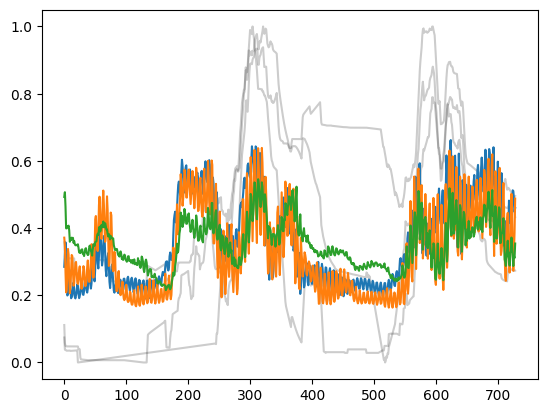

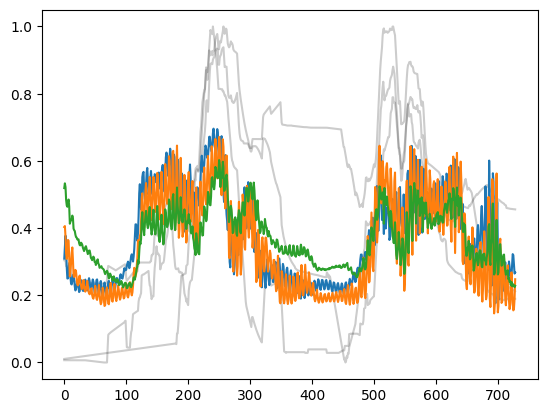

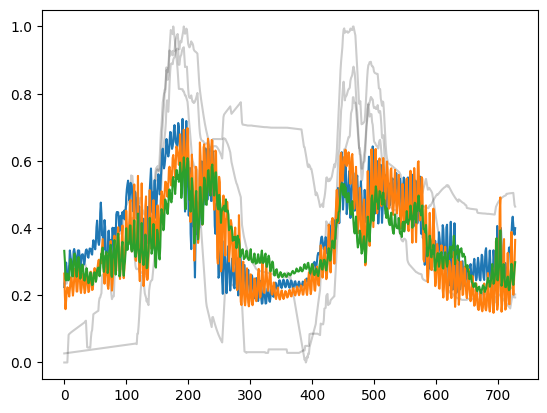

In [91]:
for batch in test_batches:
    X_test, y_test = batch

    batch_pred = ts_model(X_test, training=False)

    plt.plot(y_test[0][:, :3], alpha=0.2, color='k')
    plt.plot(batch_pred[0][:, :3])
    plt.show()